In a follow-up analysis, we can look at multi-class classification instead of merely binary --- instead of simply predicting whether a species prefers forests or not, we can see if we can predict their exact habitat, based on the data already scraped from Cornell.

To do so, instead of using only the GIS data for forests, we can use other geographical data openly available --- for example, there is the National Hydrography Dataset (NHD), located here: https://www.usgs.gov/national-hydrography/access-national-hydrography-products. We can use the NHD for NYS to determine the probability that a bird population is near a waterway, and use that as another variable in our model.

In a similar vein, the "Significant Natural Communities" data already used in this analysis has other features, like wetlands, uplands, and lakes, which can be used to determine their own similar probabilities. This means that in the dataframe for each variable in the model, each habitat will be associated with a float between 0 and 1.

In this case, to predict the habitat for a given probability: for each variable, the habitat in the dataframe with the closest probability is the predicted habitat for that variable. The overall predicted habitat is the mode of the variable's predictions.

Install and needed packages

In [12]:
library(rlang)
for (package in list("sf","xml2","units","data.table","httr","nloptr")){
    if (!is.null(catch_cnd(library(package,character.only = TRUE, quietly = T), classes="error"))){
        install.packages(package)
    }
}

library(IRdisplay)

Convienence function for downloading kml files from dec

In [2]:
download_kml=function(name){
    filename=sprintf("%s.kmz",name)
    filepath=file.path("data",filename)

    if (file.exists(sub("(\\.kmz)$",".kml",filepath))){
        return()
    }

    dir.create("data")
    download.file( paste("http://www.dec.ny.gov/maps/",filename,sep=""), filepath,mode="wb")
    unzip(filepath,exdir="data")
    file.remove(filepath)
}

Download needed files into `data` directory

In [3]:
for (region in list("southeast","west","north")){
    download_kml(sprintf("bba%s",region))
}

for (comm in list("12","34","56","789")){
     download_kml(sprintf("natcomm%s",comm))
}

download_kml("bluelines")

if (file.exists(file.path("data","doc.kml"))){ #Don't know why this only occurs for the "Blue Lines" KML
    file.rename(file.path("data","doc.kml"),file.path("data","bluelines.kml"))
}

filepath=file.path("data","DEC_Lands.kml")
if (!file.exists(filepath)){
download.file("https://opendata.arcgis.com/api/v3/datasets/84b4cce8a8974c31a1c5584540f3aaae_0/downloads/data?format=kml&spatialRefId=4326&where=1%3D1",filepath)
}

NULL

Convienence Function to convert list of coordinates to polygon

In [96]:
forested_lands=list()
sf_use_s2(FALSE)
xml_to_polygon=function(coordinates){
        coordinates=xml_text(coordinates)
        coordinates=gsub("^\\s*","",coordinates) #Removes newlines in the beginning and end of string
        coordinates=gsub("\\s*$","",coordinates)
    
        coordinates=strsplit(coordinates," ")[[1]] #Converts "a,b,c d,e,f" to ["a,b,c", "d,e,f"] 

        coordinates=lapply(coordinates, function (str) head( unlist(strsplit(str,",",fixed=T)), 2)) #Converts ["a,b,c"] to [["a","b"]]          
                
        coordinates=lapply(coordinates, function (lst) as.double(lst)) #Converts [["a","b"]] to [[a,b]]

        coordinates=matrix(unlist(coordinates),ncol=2,byrow=TRUE) #Converts a list of lists to a matrix
        coordinates= st_polygon(list(coordinates))

        coordinates=st_sfc(coordinates,crs=4326) #Mandated by KML specification

        coordinates=st_transform(coordinates,crs=5070) #Conus Albers --- equal area projection covering NA. Also much faster than using s2. Accurate areas (compared to data/source_of_truth.csv) up to the thousandths place.
                           
        coordinates=st_make_valid(coordinates) #st_concave_hull is also a valid option
                           
        coordinates
}     

Spherical geometry (s2) switched off



Load geometries from DEC_Lands and take the union of it --- this is the collection of all officially recognized forested areas in NYS, and will be used as our proxy for forested regions.

In [97]:
dec_lands=as_xml_document(file.path("data","DEC_Lands.kml"))
ns=xml_ns(dec_lands)
ns=xml_ns_rename(ns, d1="kml")

locations=xml_find_all(dec_lands,"//kml:coordinates",flatten=TRUE,ns=ns)
forested_lands=append(forested_lands,lapply(locations,xml_to_polygon))

print(tail(forested_lands,10))

[[1]]
Geometry set for 1 feature 
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 1754152 ymin: 2382622 xmax: 1754271 ymax: 2382680
Projected CRS: NAD83 / Conus Albers


POLYGON ((1754152 2382646, 1754157 2382680, 175...




[[2]]
Geometry set for 1 feature 
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 1833006 ymin: 2303594 xmax: 1834952 ymax: 2305545
Projected CRS: NAD83 / Conus Albers


POLYGON ((1833843 2303663, 1833812 2303991, 183...




[[3]]
Geometry set for 1 feature 
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 1822448 ymin: 2392522 xmax: 1822954 ymax: 2393058
Projected CRS: NAD83 / Conus Albers


POLYGON ((1822688 2392533, 1822689 2392522, 182...




[[4]]
Geometry set for 1 feature 
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 1821320 ymin: 2392912 xmax: 1821879 ymax: 2393296
Projected CRS: NAD83 / Conus Albers


POLYGON ((1821730 2393028, 1821398 2392912, 182...




[[5]]
Geometry set for 1 feature 
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 1820553 ymin: 2393000 xmax: 1826808 ymax: 2402402
Projected CRS: NAD83 / Conus Albers


POLYGON ((1824815 2402402, 1825193 2401336, 182...




[[6]]
Geometry set for 1 feature 
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 1821859 ymin: 2397472 xmax: 1822619 ymax: 2398326
Projected CRS: NAD83 / Conus Albers


POLYGON ((1822345 2398326, 1822359 2397922, 182...




[[7]]
Geometry set for 1 feature 
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 1630240 ymin: 2364834 xmax: 1637504 ymax: 2373120
Projected CRS: NAD83 / Conus Albers


POLYGON ((1634367 2369641, 1634424 2369458, 163...




[[8]]
Geometry set for 1 feature 
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 1771910 ymin: 2343457 xmax: 1782676 ymax: 2352383
Projected CRS: NAD83 / Conus Albers


POLYGON ((1772944 2348908, 1772549 2349037, 177...




[[9]]
Geometry set for 1 feature 
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 1782677 ymin: 2345048 xmax: 1782684 ymax: 2345081
Projected CRS: NAD83 / Conus Albers


POLYGON ((1782684 2345081, 1782677 2345048, 178...




[[10]]
Geometry set for 1 feature 
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 1777560 ymin: 2340198 xmax: 1787095 ymax: 2346031
Projected CRS: NAD83 / Conus Albers


POLYGON ((1783488 2345517, 1783583 2345478, 178...



Extract all Forested Uplands (what we would call "forests") from "Significant Natural Communities" data.

In [98]:
for (comm in list("12","34","56","789")){
    filename=sprintf("natcomm%s.kml",comm)
    filepath=file.path("data",filename)
    natcomm=as_xml_document(filepath)

    ns=xml_ns(natcomm)
    locations=xml_find_all(natcomm,'//kml:Folder[kml:name[text()="Forested Uplands"]]//kml:LinearRing//kml:coordinates',flatten=TRUE,ns=ns)
    forested_lands=append(forested_lands,lapply(locations,xml_to_polygon))
    
}
print(tail(forested_lands,10))

[[1]]
Geometry set for 1 feature 
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 1392160 ymin: 2282894 xmax: 1392274 ymax: 2283173
Projected CRS: NAD83 / Conus Albers


POLYGON ((1392252 2283173, 1392272 2283161, 139...




[[2]]
Geometry set for 1 feature 
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 1392097 ymin: 2283845 xmax: 1392484 ymax: 2284155
Projected CRS: NAD83 / Conus Albers


POLYGON ((1392320 2284155, 1392321 2284153, 139...




[[3]]
Geometry set for 1 feature 
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 1391591 ymin: 2282769 xmax: 1391998 ymax: 2283367
Projected CRS: NAD83 / Conus Albers


POLYGON ((1391927 2283352, 1391954 2283363, 139...




[[4]]
Geometry set for 1 feature 
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 1391018 ymin: 2283876 xmax: 1391149 ymax: 2284025
Projected CRS: NAD83 / Conus Albers


POLYGON ((1391113 2284015, 1391107 2284009, 139...




[[5]]
Geometry set for 1 feature 
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 1338692 ymin: 2257831 xmax: 1340941 ymax: 2259576
Projected CRS: NAD83 / Conus Albers


POLYGON ((1339588 2257900, 1339561 2257890, 133...




[[6]]
Geometry set for 1 feature 
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 1483291 ymin: 2387262 xmax: 1484577 ymax: 2388982
Projected CRS: NAD83 / Conus Albers


POLYGON ((1483551 2387863, 1483552 2387833, 148...




[[7]]
Geometry set for 1 feature 
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 1395603 ymin: 2246986 xmax: 1396820 ymax: 2248201
Projected CRS: NAD83 / Conus Albers


POLYGON ((1396820 2247846, 1396811 2247249, 139...




[[8]]
Geometry set for 1 feature 
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 1579013 ymin: 2315583 xmax: 1579470 ymax: 2316144
Projected CRS: NAD83 / Conus Albers


POLYGON ((1579377 2316107, 1579401 2315991, 157...




[[9]]
Geometry set for 1 feature 
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 1421048 ymin: 2258773 xmax: 1423013 ymax: 2260941
Projected CRS: NAD83 / Conus Albers


POLYGON ((1421094 2260918, 1421130 2260924, 142...




[[10]]
Geometry set for 1 feature 
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 1410380 ymin: 2261596 xmax: 1411682 ymax: 2262750
Projected CRS: NAD83 / Conus Albers


POLYGON ((1410422 2262231, 1410392 2262310, 141...



Extract all State Reserves (which are definitely forests) from "Blue Lines" data.

In [99]:
filepath=file.path("data","bluelines.kml")
bluelines=as_xml_document(filepath)

ns=xml_ns(bluelines)
locations=xml_find_all(bluelines,'//kml:coordinates',flatten=TRUE,ns=ns)
forested_lands=append(forested_lands,lapply(locations,xml_to_polygon))
print(tail(forested_lands,10))

[[1]]
Geometry set for 1 feature 
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 1391591 ymin: 2282769 xmax: 1391998 ymax: 2283367
Projected CRS: NAD83 / Conus Albers


POLYGON ((1391927 2283352, 1391954 2283363, 139...




[[2]]
Geometry set for 1 feature 
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 1391018 ymin: 2283876 xmax: 1391149 ymax: 2284025
Projected CRS: NAD83 / Conus Albers


POLYGON ((1391113 2284015, 1391107 2284009, 139...




[[3]]
Geometry set for 1 feature 
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 1338692 ymin: 2257831 xmax: 1340941 ymax: 2259576
Projected CRS: NAD83 / Conus Albers


POLYGON ((1339588 2257900, 1339561 2257890, 133...




[[4]]
Geometry set for 1 feature 
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 1483291 ymin: 2387262 xmax: 1484577 ymax: 2388982
Projected CRS: NAD83 / Conus Albers


POLYGON ((1483551 2387863, 1483552 2387833, 148...




[[5]]
Geometry set for 1 feature 
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 1395603 ymin: 2246986 xmax: 1396820 ymax: 2248201
Projected CRS: NAD83 / Conus Albers


POLYGON ((1396820 2247846, 1396811 2247249, 139...




[[6]]
Geometry set for 1 feature 
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 1579013 ymin: 2315583 xmax: 1579470 ymax: 2316144
Projected CRS: NAD83 / Conus Albers


POLYGON ((1579377 2316107, 1579401 2315991, 157...




[[7]]
Geometry set for 1 feature 
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 1421048 ymin: 2258773 xmax: 1423013 ymax: 2260941
Projected CRS: NAD83 / Conus Albers


POLYGON ((1421094 2260918, 1421130 2260924, 142...




[[8]]
Geometry set for 1 feature 
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 1410380 ymin: 2261596 xmax: 1411682 ymax: 2262750
Projected CRS: NAD83 / Conus Albers


POLYGON ((1410422 2262231, 1410392 2262310, 141...




[[9]]
Geometry set for 1 feature 
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 1638287 ymin: 2424667 xmax: 1798979 ymax: 2637247
Projected CRS: NAD83 / Conus Albers


POLYGON ((1742298 2635913, 1742735 2634226, 174...




[[10]]
Geometry set for 1 feature 
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 1706705 ymin: 2287567 xmax: 1793505 ymax: 2352721
Projected CRS: NAD83 / Conus Albers


POLYGON ((1775622 2351833, 1780161 2350072, 177...



Take union of list to make multi-polygon, and resolve any border overlaps

In [100]:
forested_lands=do.call(c, forested_lands)

forested_lands=st_union(forested_lands)

forested_lands=st_cast(forested_lands,"POLYGON") #So I can run intersects/intersection on each non-overlapping region independently

forested_lands=st_make_valid(forested_lands) #For some reason, while each part is valid, the union is not --- likely due to precision

print(forested_lands)

Geometry set for 2655 features 
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 1324658 ymin: 2151820 xmax: 1990721 ymax: 2657514
Projected CRS: NAD83 / Conus Albers
First 5 geometries:


POLYGON ((1342800 2228849, 1343109 2228891, 134...

POLYGON ((1341951 2228736, 1341925 2228895, 134...

POLYGON ((1354805 2230352, 1354690 2230343, 135...

POLYGON ((1349979 2230982, 1349960 2230978, 134...

POLYGON ((1361083 2231705, 1361267 2231747, 136...



Picture of all Forested Lands

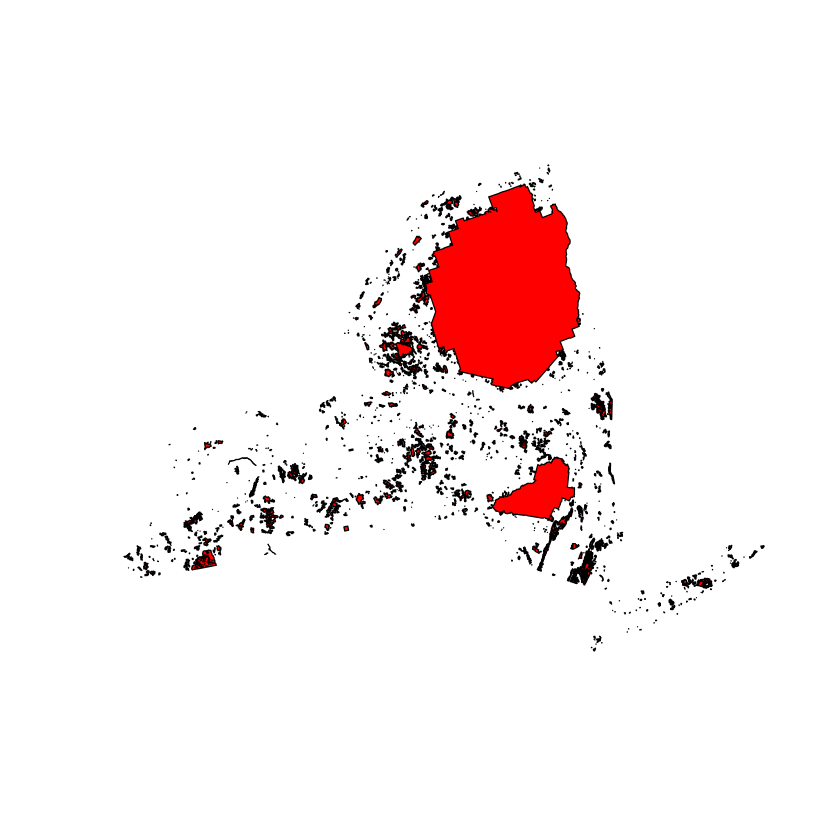

In [101]:
plot(forested_lands,col="red")

Create dataframes to hold each subplot and bird:
Each row in `subplots` will hold the polygon associated with it

Each row in `birds` will hold the name of the bird and the list of subplots that it was found in.

In [104]:
subplots=data.frame(in_forested=I(list()),area=I(list()))

birds=data.frame(name=I(list()),plots=I(list()),total_in_forested=I(list()),total_area=I(list()))

Parse the Bird Breeding Atlas data to get the geometries of the subplots, and the birds that were found in each region. 

We are assuming that for a given bird species, the populations are equally distributed over all the blocks that they are found in --- in a follow-up analysis, we can use a population density map, to get more fine-grained information about the concentration of a population in different regions.
    How this would work: assume that some block of land $l$ has a population density of $d\%$ for bird species $s$ --- that is, $d\%$ of the entire population of $s$ in NYS lives in $l$. We assume that within $l$, the population is uniformly distributed (it's the same assumption as before, but now over a smaller piece of land, so it should hopefully be more accurate). So, if $f\%$ of $l$ is in forested lands, then $(f\cdot d)\%$ of the population of $s$ lives in forested lands.

In [105]:
subplots_idx=1
forested_lands_crs=st_crs(forested_lands)

for (region in list("southeast","west","north")){
    filename=sprintf("bba%s.kml",region)
    filepath=file.path("data",filename)
    bba=as_xml_document(filepath)
    
    for (location in xml_find_all(bba,".//kml:Placemark",flatten=TRUE)){
        coordinates=xml_find_first(location,".//kml:LinearRing/kml:coordinates")
        coordinates=xml_to_polygon(coordinates)

        intersects=st_intersects(coordinates,forested_lands)[[1]] #Filter out any forests that do not intersect with the block
        
        if (length(intersects)>0){ #If there's at least one intersection
        intersections=lapply(intersects, function (region) st_intersection(coordinates, st_sfc(forested_lands[region],crs=forested_lands_crs)) ) #Get the intersections

        intersections=lapply(intersections, function (region) st_area(region)) #Get the area of the intersections

        intersections=sum(unlist(intersections)) #Sum 'em up
        }else{
            intersections=0
        }
     
        area=drop_units(st_area(coordinates))
                        
        subplots[[subplots_idx,"in_forested"]]=intersections
        subplots[[subplots_idx,"area"]]=area
        
        for (bird in xml_find_all(location,".//kml:SimpleData")){
            identifier=xml_attr(bird,"name")
            name=xml_text(bird)
            if (name=="NONE"){ #None was found here, so can skip
                next
            }
            if (!grepl("^\\s*$",name)[[1]]){ #Name has to be a string
                birds[[identifier,"name"]]=name
            }else{
                next #We take it to mean that a blank means "possible" --- we only want "certain"
            }
            
            locations_list=birds[[identifier,"plots"]]
            
            if (is.na(list(locations_list)) || is.null(list(locations_list))){
                locations_list=c()
            }
            
            locations_list=append(locations_list,subplots_idx)
            
            birds[[identifier,"plots"]]=locations_list

         }
        clear_output()
        print(sprintf("Finished processing plot %s!", subplots_idx))
        flush.console()
         subplots_idx=subplots_idx+1
    }
}

print(head(subplots,10))
print(head(birds,10))                          

[1] "Finished processing plot 5336!"
    in_forested         area
1             0 24986969....
2             0 25019851....
3             0 25019639....
4             0 25019619....
5  8478801..... 25019680....
6             0 25019660....
7  1009170..... 25019529....
8  14631986.... 25019700....
9             0 25019432....
10 1724152..... 25019388....
             name        plots total_in_forested total_area
GRHE Green He.... 2, 21, 2....                             
BAOR Baltimor.... 2, 3, 4,....                             
COGR Common G.... 2, 3, 4,....                             
RWBL Red-wing.... 2, 3, 4,....                             
BCCH Black-ca.... 2, 3, 4,....                             
ETTI Tufted T.... 2, 3, 4,....                             
AMGO American.... 2, 3, 4,....                             
INBU Indigo B.... 2, 3, 4,....                             
NOCA Northern.... 2, 4, 5,....                             
RTHU Ruby-thr.... 2, 3, 4,....              

For each bird species, find $P(\text{In Forested}\ |\ \text{Bird})$. This is calculated with (Intersection between lands where species is found and forested areas)/(All lands where species is found). 

Why this works:
==============
Assume that for a species $s$, all populations are uniformly distributed over all lands where they are found in NYS --- that is, if a population of $s$ is in land $l$, then the population density is $d$, where $d$ is a constant.

This means that if total area of lands where $s$ is found is $A$ and the total number of birds of $s$ in NYS is $N$, then $N=bA$. Assume the area intersection of the lands where species is found and forested areas is $I$. This means that all of the birds of $s$ that live in forested areas is $bI$. So, the proportion of all birds in $s$ that live in forested areas is $\frac{bI}{bA}=\frac{I}{A}$.

We can simply add the intersections and areas from each of the plots $s$ is in, as each plot does not overlap another plot, so they are independent. Similarly, we can add up the intersections each plot has with each forest as each forest is independent (there is no overlap).

In [106]:
for (i in seq_len(nrow(birds))){

    total_in_forested=0
    total_area=0

    plots=birds[[i,"plots"]]

    for (plot in plots){

        total_in_forested=total_in_forested+subplots[[plot,"in_forested"]]
        total_area=total_area+subplots[[plot,"area"]]
    }

    birds[[i,"total_in_forested"]]=total_in_forested
    birds[[i,"total_area"]]=total_area
        
}

print(head(birds,10))

             name        plots total_in_forested   total_area
GRHE Green He.... 2, 21, 2....      39750729.... 55332158....
BAOR Baltimor.... 2, 3, 4,....      13346995.... 10692337....
COGR Common G.... 2, 3, 4,....      25124495.... 12333167....
RWBL Red-wing.... 2, 3, 4,....      25069737.... 12455651....
BCCH Black-ca.... 2, 3, 4,....      31625449.... 13016128....
ETTI Tufted T.... 2, 3, 4,....      86124984.... 78039338....
AMGO American.... 2, 3, 4,....      26515808.... 12510714....
INBU Indigo B.... 2, 3, 4,....      18292591.... 10569963....
NOCA Northern.... 2, 4, 5,....      87275321.... 97413283....
RTHU Ruby-thr.... 2, 3, 4,....      25540683.... 10637786....


Save the probabilities to a CSV file for further analysis.

In [107]:
print(identical(birds[[1,"plots"]],birds[[2,"plots"]]))
birds_csv_df=copy(birds)
birds_csv_df$total_in_forested=unlist(birds_csv_df$total_in_forested)
birds_csv_df$total_area=unlist(birds_csv_df$total_area)

birds_csv_df=transform(birds_csv_df, probability=total_in_forested/total_area) #df that will be written to a csv

birds_csv_df=subset(birds_csv_df,select=-c(plots,total_in_forested,total_area))

write.csv(birds_csv_df,file="analysis_results.csv",row.names=F)

[1] FALSE


We can say that any deviation is due to the birds adapting to changing environment. May not account for other features that are or are not in forests (water, shrubs, cliffs, etc.).

Scrape [All About Birds](https://www.allaboutbirds.org/) to get the habitat associated with each type of bird

Remove "'", and replace " " with "_", to normalize names for URLs. For any bird that does not have an associated page, ignore it in the final model.

In [36]:
birds=read.csv("analysis_results.csv")

preferred_habitats="preferred_habitats.csv"
if (!file.exists(preferred_habitats)){ #Create table
    columns=c("name","habitat")
    
    write.csv(data.frame(matrix(ncol=length(columns),nrow=0, dimnames=list(NULL, columns ))),file=preferred_habitats,row.names=F)
}

habitat_not_found=c()

print_progress = function (name,success) {
    clear_output()

    if (length(habitat_not_found)>0){
        for (elem in habitat_not_found){
            cat(sprintf("%s not Found!\n",elem))
        }
        cat("\n\n")
    }
    
    if (success){
        cat(sprintf("%s Found!\n",name))
    }else{
        habitat_not_found <<- append(habitat_not_found,name)
        write.table(list(name,""),file=preferred_habitats,append=T,sep=",",row.names=F, col.names=F)
        cat(sprintf("%s Not Found!\n",name))
    }
    flush.console()
}

for (i in nrow(read.csv(preferred_habitats))+1:nrow(birds)){
    if (i>nrow(birds)){
        break
    }
    
    name=birds[i,"name"]
    original_name=name #To save to csv

    cat(sprintf("Now processing %s...\n\n",original_name))
    name=gsub("^(.+) \\(.*","\\1",name)

    name=gsub("'","",name,fixed=T)
    name=gsub(" ","_",name,fixed=T)
    
    page=GET(sprintf("https://www.allaboutbirds.org/guide/%s/",name))
    if (status_code(page)==404){
        print_progress(original_name,success=F)
        next
    }

    page=content(page,as="parsed")
    
    habitat=xml_find_first(page,sprintf("//a[@href =\"/guide/%s/lifehistory#habitat\"]",name))

    if (is.na(habitat)){
        print_progress(original_name,success=F)
        next
    }
    habitat=xml_find_first(habitat,"//span[@class=\"text-label\"]")
    if (is.na(habitat)){
        print_progress(original_name,success=F)
        next
    }
    
    habitat=xml_text(habitat)

    habitat=gsub("^Habitat","",habitat)

    write.table(list(original_name,habitat),file=preferred_habitats,append=T,sep=",",row.names=F, col.names=F)

    print_progress(original_name,success=T)
}
cat("\n\n")
read.csv(preferred_habitats)

name,habitat
<chr>,<chr>
Green Heron (Butorides virescens),Marshes
Baltimore Oriole (Icterus galbula),Forests
Common Grackle (Quiscalus quiscula),Open Woodlands
Red-winged Blackbird (Agelaius phoeniceus),Marshes
Black-capped Chickadee (Poecile atricapillus),Forests
Tufted Titmouse (Baeolophus bicolor),Forests
American Goldfinch (Carduelis tristis),Open Woodlands
Indigo Bunting (Passerina cyanea),Open Woodlands
Northern Cardinal (Cardinalis cardinalis),Open Woodlands


Now it's time to do the actual model training:
There is only one parameters: 

cutoff, which is a value such that if r is larger than cutoff, the associated bird is considered to prefer forested areas over non-forested areas; and 

We will optimize the model function with exhaustive search.

To account for potential class imbalance between forests and non-forests, the accuracy at each is calculated on a hypothetial data set in which both classes have a proportion of 50%.

Important combinatronics functions

In [2]:
convert_num_to_permutation=function(num,k,lst){ #Converts num to permuation of choosing k items chosen out of n items without repetition.
    result=c()

    n=length(lst)-1 #[0,n-1]-> [1,n]
    i=n-(k-1)
    curr=num

    while(i<=n){ #https://en.wikipedia.org/wiki/Factorial_number_system#Definition
        idx=(curr %% i)+1

        result=append(result, lst[idx])

        lst=lst[-idx]
        
        curr=curr %/% i
        i=i+1
    }
    return(result)
}
                   
convert_num_to_base=function(num,k,lst){ #Converts num to permuation of choosing k items chosen out of n items with repetition.
    result=c()

    n=length(lst)
    i=1

    curr=num
    while(i<=k){
        result=append(result, lst[(curr %% n)+1])
        curr=curr %/% n
        i=i+1
    }

    return(result)
}

Perm=function(n,k){choose(n,k) * factorial(k)} #Calculates number of permutations of k items chosen out of n items without repetition

In [4]:
birds=read.csv("analysis_results.csv")
preferred_habitats=read.csv("preferred_habitats.csv")

accuracy=0
habitats=unique(preferred_habitats$habitat)
cutoffs=c()
weights=c()

model_predict=function(bird,weights,cutoffs){
    forested_count=0
    nonforested_count=0

    probabilities=birds[birds$name==bird,2:ncol(birds)]
    
    for (i in 1:length(probabilities)){
        if (probabilities[i]>cutoffs[i]){
            forested_count=forested_count+weights[i]
        }else{
            nonforested_count=nonforested_count+weights[i]
        }
    }
    if (forested_count>nonforested_count){
        return(T)
    }else{
        return(F)
    }
            
}

model_accuracy=function(weights,cutoffs){
    forested_num=0
    forested_right=0

    non_forested_num=0
    non_forested_right=0

    for (i in 1:nrow(preferred_habitats)){
        habitat=preferred_habitats[i,"habitat"]
        if (habitat==""){
            next
        }
        forested=(habitat=="Forests")
        right=(forested==model_predict(birds[i,"name"],weights,cutoffs))
        
        if (forested){
            forested_num=forested_num+1
            if (right){
                forested_right=forested_right+1
            }
        }else{
            non_forested_num=non_forested_num+1
            if (right){
                non_forested_right=non_forested_right+1
            }
        }
    }
    
    return((forested_right/forested_num)*1/2+(non_forested_right/non_forested_num)*1/2)
}   

i=0
while( i<= 101^(ncol(birds)-1)){
    j=0
    cutoffs_vector=convert_num_to_base(i,ncol(birds)-1,seq(0,1,0.01))
    while( j<= 101^(ncol(birds)-1)){
        weights_vector=convert_num_to_base(j,ncol(birds)-1,seq(0,1,0.01))
        
        if (sum(weights_vector)!=1){
            j=j+1
            next
        }
        possible_accuracy=model_accuracy(weights_vector,cutoffs_vector)
        if (possible_accuracy>accuracy){
            clear_output()
            accuracy=possible_accuracy
            cutoffs=cutoffs_vector
            weights=weights_vector
            cat(sprintf("New accuracy is %s %% with cutoff vector\n",round(accuracy*100,digits=2)))
            print(cutoffs)
            cat("\nand weights vector\n")
            print(weights)
            flush.console()
        }
        j=j+1
    }
    i=i+1
}
cat("\n\n")
print("Finished!")

New accuracy is 75.3 % with cutoff vector
[1] 0.23

and weights vector
[1] 1


[1] "Finished!"


Now, we'll try a different model: instead of binary classification, we'll try multi-class classification. 

The model will now have len(habitats) parameters --- each parameter (which is in \[0,1]) will be associated with a habitat. The parameter which is closest to r will be the predicted habitat (with n calculated probabilities, we can have n*len(habitats) parameters. For probabilities\[i], the habitat predicted for that probability will be the habitats\[j] where parameters\[i]\[j] is the the closest value in parameters\[i] to probabilities\[i]. The overall predicted habitat is the mode of the predictions across all probabilities). 

In [ ]:
birds=read.csv("analysis_results.csv")
preferred_habitats=read.csv("preferred_habitats.csv")

accuracy=-Inf
habitats=unique(preferred_habitats$habitat)
parameters=data.frame()
weights=list()

create_parameters_df=function(habitats,vector){
    parameters_df=data.frame(A=vector)
    rownames(parameters_df)=habitats
    return(parameters_df)
}

model_predict=function(probabilities,weights,parameters){
    weights=weights/sum(weights) #Scale weights
    predictions=data.frame(count=rep(0,nrow(parameters))) #Storing the weight of the predictions of each possible class

    rownames(predictions)=rownames(parameters)
    
    for (i in 1:length(probabilities)){
        probabilities_i=probabilities[i] #Get the probability corresponding to the ith variable
        parameters_i=parameters[i] #Get the values associated with each class for the ith variable

        parameters_i=parameters_i[order(parameters_i[,1], decreasing=F),,drop=F] #Sort the values in ascending order

        closest_parameter_index=findInterval(probabilities_i,parameters_i[,1]) #Find index closest without going over.

        if (closest_parameter_index==nrow(parameters_i)){ #In another run, comment out this if-ladder
            closest_parameter_index=closest_parameter_index
        }else if (closest_parameter_index==0){
            closest_parameter_index=1
        }else if ((probabilities_i-parameters_i[closest_parameter_index,1]) < ((parameters_i[closest_parameter_index+1,1]-probabilities_i)+0.001)){ #The 0.001 is used to make sure that two values that are the same will not lead to the same distance
            closest_parameter_index=closest_parameter_index
        }else{
            closest_parameter_index=closest_parameter_index+1
        }

     closest_parameter=rownames(parameters_i)[closest_parameter_index]
        predictions[closest_parameter,"count"]=predictions[closest_parameter,"count"]+weights[i]
    }

    predictions=predictions[order(predictions$count,decreasing=T),,drop=F]
    return(rownames(predictions)[1]) #Get the name of the row with the highest count
}
    
model_accuracy=function(weights,parameters){
    counts=data.frame(right=rep(0,nrow(parameters)),num=rep(0,nrow(parameters)))

    rownames(counts)=rownames(parameters)
    
    counts=counts[!(rownames(counts) %in% c("")),] #Don't consider habitat ""

    for (i in 1:nrow(birds)){
        habitat=preferred_habitats[i,"habitat"]
        if (habitat==""){
            next
        }
        right=(model_predict(birds[i,2:ncol(birds)],weights,parameters)==habitat)

        counts[habitat,"num"]=counts[habitat,"num"]+1

        if (right){
           counts[habitat,1]=counts[habitat,1]+1 
        }
    }

    accuracy=apply(counts,1, function(row) row[1]/row[2])

    accuracy=sum(accuracy)/nrow(counts)

    return(accuracy)
}
if (F){ #Based off of exhaustive search --- will take too long

i=0
while (i <= (Perm(101,length(habitats)-1))){
    
parameters_df=create_parameters_df(habitats,convert_num_to_permutation(i,length(habitats),seq(0,1,0.01)))

    j=0
    
    while ( j<= 101^(ncol(birds)-1)){
        weights_vector=convert_num_to_base(j,ncol(birds)-1,seq(0,1,0.01))
        if (sum(weights_vector)!=1){
            j=j+1
            next
        }
        possible_accuracy=model_accuracy(weights_vector,parameters_df)
        
        if (possible_accuracy>accuracy){
            clear_output()
            
            accuracy=possible_accuracy
            weights=weights_vector
            parameters=parameters_df
            
            cat(sprintf("New accuracy is %s %% with weights vector\n", round(accuracy*100,digits=2)))
            print(weights_vector) 
            cat("\nand parameters\n")
            print(parameters_df)
            flush.console()
        }
        j=j+1
    }
    i=i+1
}
}else{ #Based off of nloptr --- could never get working
    num_of_habitats_vars=length(habitats)
    num_of_weight_vars=ncol(birds)-1

    eval_f=function(vector){
        parameters_df=create_parameters_df(habitats,vector[1:num_of_habitats_vars])
        weights_vector=vector[(num_of_habitats_vars+1):length(vector)]
        result=model_accuracy(weights_vector,parameters_df)
        clear_output()
        print(result)
        flush.console()
        return(-result)
    }
    
    x0=append(rep(0,num_of_habitat_vars),append(rep(0,num_of_weight_vars-1),1))
    
    lb=rep(0,length(x0))

    ub=rep(1,length(x0))

    print(nloptr(x0=x0,eval_f=eval_f,lb=lb,ub=ub ,opts=list("algorithm"="NLOPT_GN_DIRECT_L","maxeval"=10000)))                                                  
}                                                          

[1] 0.2150208
